# CONFUSION Demo Notebook  

This notebook uses visual representations to check the the dimentions of each input and output.

Then, we test different methods for unpacking the linear layer at the end of the recurrent mechanism.

In [1]:
import numpy as np
import pandas as pd
import sys, os
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import talib as ta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# MAKE SURE WE HAVE THE ENVIRONMENT CONFIGURED PROPERLY
%cd ../src/main
SCRIPT_DIR = os.path.dirname(os.path.abspath("."))
if 'backend' not in os.listdir('.'):
    sys.path.insert(0, os.path.abspath(SCRIPT_DIR))

from backend.utils import DataIterGen_V2
from backend.technical_analysis import get_data_set_V2
from backend.reinforcement_learning import tam

/home/jackb/columbia/TFJ-DRL-update1/src/main


Getting CUDA

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device(f'cuda:{torch.cuda.device_count()-1}')
else:
    DEVICE = torch.device('cpu')

WINDOW = 28
NAME = "conf_posthoc_"
ENV_SIZE = 128
DEVICE

device(type='cuda', index=0)

### Definining the recurrent attention (supervised) model

We will modify the feed-forward (`nn.Linear`) portion of the model to return the latent representation of the price at $t+1$

Before we have $W_1 \in \mathbb{R^{256 \times \text{env\_size}}}$, $W_2 \in \mathbb{R^{\text{env\_size} \times \text{1}}}$:

$$\hat{\text{price}}_{t+1} = RELU(W_1 \cdot (h_t \oplus \text{attention}(h_t)))W_2$$


To 'crack open' the model we will change its forward function to return the hidden vector $RELU(W_1 \cdot (h_t \oplus \text{attention}(h_t)))$. This is primarily what we will test on.

In [3]:
class GRU(nn.Module):
    def __init__(self, env_size):
        super(GRU, self).__init__()
        self.rnn=nn.GRU(
            input_size=86,
            hidden_size=128,
            num_layers=1,
            batch_first=True
        )
        self.linear1=nn.Linear(256, env_size)
        self.linear2=nn.Linear(env_size, 1)
        self.num_layers=1
        
    def forward(self, x, state, device):
        batch_size,timestep, _=x.shape
        states, state=self.rnn(x, state)
        tamVec=tam(states, device)
        
        #concatVec: batch_size, time_step, hidden_size*2
        #i.e.       batch_size, 24       , 256        
        concatVec=torch.cat([states, tamVec],axis=2)
        envVec=self.linear1(torch.tanh(concatVec.reshape(batch_size*timestep, -1)))
        output=nn.Dropout(p=0.3)(envVec)
        output=nn.ReLU()(output)
        # hidden_output=nn.ReLU()(output) # HERE
        output=self.linear2(output)
        envVec=envVec.reshape(batch_size, timestep, -1)
        return (output.view(batch_size, -1), envVec), state#, hidden_output
  
    def begin_state(self, device, batch_size=1): 
        # `nn.GRU` takes a tensor as hidden state
        return torch.zeros((
                    self.rnn.num_layers, batch_size, 128), device=device)

tam_gru = GRU(env_size=ENV_SIZE).to(DEVICE)
tam_gru

GRU(
  (rnn): GRU(86, 128, batch_first=True)
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

We need to redefine the `rlPolicy` agent as well. The `rlPolicy` agent is the one which recieves the loss at a given timestep $t$ during training, so it needs to pass that loss backwards to the `tam_gru` model as well.

Between the `tam_gru` model and policy agent we add a decoder model which reconstructs the `hidden_state` vector from the `hidden_output` vector.

To train the decoder, need a new loss function on top of the loss function from the paper. This new loss will be the angular difference between the `hidden_output` vector and the `predicted_hidden_output` vector. As we track this loss through time, it may clue us in to the `tam_gru` model's ability to represent the state. Higher loss means the `tam_gru` is treading uncharted territory, so to speak, which makes the policy agent ***confused***. This is how the decoder loss functions as a confusion metric for the model.


In [4]:
class AutoEncoder(nn.Module):
    """Auto-encoder to get a latent representation of the hidden state, 
    then decode to get the confusion"""
    def __init__(self, env_size, device: torch.device, window):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
           nn.Linear(env_size*window, 64),
           nn.LeakyReLU(),
           nn.Dropout(p=0.3),
           nn.Linear(64, 16),
           nn.ReLU(),
           nn.Linear(16, 2)
        )


        self.decoder = nn.Sequential(
           nn.Linear(2, 16),
           nn.LeakyReLU(),
           nn.Dropout(p=0.3),
           nn.Linear(16, 64),
           nn.ReLU(),
           nn.Linear(64, env_size*window)
       )
       
        self.env_size = env_size
        self.window = window
    
    def forward(self, x):
        bsize = x.shape[0]
        x = x.flatten(start_dim=1)
        hidden = self.encoder(x)
        output = self.decoder(hidden)
        output = output.reshape(bsize, self.window, self.env_size)
        hidden = hidden.reshape(bsize, 1, 2)
        return hidden, output

decoder = AutoEncoder(ENV_SIZE, DEVICE, WINDOW).to(DEVICE)
decoder

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3584, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=3584, bias=True)
  )
)

### Full Monty class

class extending nn.Module containing an instance of both the policy agent and gru-tam model.

Intended to make training easier to implement with PyTorch

In [5]:
from backend.reinforcement_learning import get_params, rlForwardFunc, rlPolicy

class full_monty(nn.Module):
    """RL Policy net modeled by parameters"""
    def __init__(self, env_size, device: torch.device, window):
        super(full_monty, self).__init__()
        
        #self.linear = nn.Linear(32+1, 1)
        
        W, b, h=get_params(env_size+1, device)
        self.device=device
        self.W=nn.Parameter(W)
        self.b=nn.Parameter(b)
        self.h=nn.Parameter(h)
        self.rnn=GRU(env_size)
        self.conf_net = AutoEncoder(env_size, device, window)

        self.device = device

    # Forward pass through the RL Policy network
    def forward(self, x, state):
        # Obtain predictions and environment vector from GRU
        (predP, envVec), state = self.rnn(x, state, self.device)
       
        # get the confusion
        envVec_copy = envVec.clone().detach()
        embed, reconstruction = self.conf_net(envVec_copy)
        bsize, tstep = reconstruction.shape[0], reconstruction.shape[1] 
        
        confusion_for_grad = nn.CosineEmbeddingLoss(reduction='none')(reconstruction.view((bsize*tstep, -1)), envVec_copy.view((bsize*tstep, -1)), torch.ones((bsize*tstep)).to(self.device))
        confusion=confusion_for_grad.clone().detach()
        confusion_for_grad = confusion_for_grad.mean() #nn.CosineEmbeddingLoss()(reconstruction.view((bsize*tstep, -1)), envVec_copy.view((bsize*tstep, -1)), torch.ones((bsize*tstep)).to(self.device))

        # Compute actions based on the environment vector and parameters
        rl_state = torch.concat((envVec, confusion.reshape(bsize, tstep, 1)), dim=2)
        output = rlForwardFunc(rl_state, [self.W, self.b, self.h])

        # Return predictions and actions
        return predP, output, (confusion, confusion_for_grad, embed)
    
    # Initialize the hidden state for the RL Policy network
    def begin_state(self, device, batch_size=1):
        return self.rnn.begin_state(device, batch_size)

combined = full_monty(ENV_SIZE, DEVICE, WINDOW)
combined

full_monty(
  (rnn): GRU(
    (rnn): GRU(86, 128, batch_first=True)
    (linear1): Linear(in_features=256, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=1, bias=True)
  )
  (conf_net): AutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=3584, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=64, out_features=16, bias=True)
      (4): ReLU()
      (5): Linear(in_features=16, out_features=2, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=16, out_features=64, bias=True)
      (4): ReLU()
      (5): Linear(in_features=64, out_features=3584, bias=True)
    )
  )
)

### Utility function defined in paper. 

$$R_t = \delta _t z_t - c|\delta_t - \delta_{t-1}| $$

$$U_t = \sum_{t=1}^T R_t$$

In [6]:
from backend.utils import calcUtility

In [7]:
from backend.utils import grad_clipping, init_weights, lossFunc, lossFunc2

# Define the new training function

Implicitly, we have 3 global models working together.

* `tam_gru`
* `decoder`
* `policy_agent`

In [8]:
#trainer for epoch
def train_epoch(train_iter, net, device, optim1, optim3, lossfn):
    loss_data=[]
    embed_list = []
    confusion_list = np.array([])
    with torch.autograd.set_detect_anomaly(True):
        for X, y, z, _ in train_iter:
            # reset state for each batch
            state= net.begin_state(batch_size=X.shape[0], device=device)
        
            # move to device
            X, y, z=X.to(device), y.to(device), z.to(device)
            
            # feed through full-monty
            predP, output, (confusion_granular, confusion, embed) = net(X, state)
            
            # ============[ ADDING DECODER LOSS CONFUSION, DREAM] =====================
            optim3.zero_grad()
            confusion.backward()
            optim3.step()
            # =========================================================================

            loss = lossfn(predP, y, output,z, device)
            optim1.zero_grad()
            loss.backward()
            grad_clipping(net, 1)
            optim1.step()
            loss_data.append(loss.item())
            confusion_list = np.append(confusion_list, confusion_granular.flatten().cpu())
    return np.array(loss_data).mean(), loss_data, confusion_list

# Define Confusion Heuristic

In [9]:
from typing import List


def apply_conf(policy: List[List], confusion: List[List], lower_thresh=0.15, upper_thresh=0.85) -> None:
    """
    confusion:  [BATCH, STEP]
    policy:     [BATCH, STEP]
    """
    x = confusion.mean(dim=-1)
    x = ((x < upper_thresh)*1) * ((x > lower_thresh)*1)
    policy[:,-1] *= x
    return policy


In [10]:
#Testing on trained model
def prediction(eval_iter, net, device, lossfn):
    net.eval()
    net.conf_net.eval()
    loss_list=[]
    U_list=[]
    embed_list=[]
    conf_list=np.array([])
    with torch.no_grad():
        for X, y, z, _ in eval_iter:
            # to device
            X, y, z = X.to(device), y.to(device), z.to(device)

            # initialize rnn state
            state=net.begin_state(batch_size=X.shape[0], device=device) # changed from net.begin

            # feed through full-monty
            predP, output, (confusion,_, embed) = net(X, state)
            
            # ==========={ HEURISTIC: APPLYING BOUNDS [0.15, 0.85] }========
            bsize = X.shape[0]
            policy = apply_conf(output, confusion)
            output = policy.reshape(output.shape) 
            # ==============================================================

            loss=lossfn(predP, y, output, z, device).float()
            U, _=calcUtility(output, z)
            loss_list.append(loss.cpu().numpy())
            U_list.append(U[:, -1].mean().cpu().numpy())
            embed_list.append(embed.flatten(0,1).cpu().numpy())
            conf_list = np.concatenate((conf_list, confusion.flatten().cpu().numpy()))
    return np.array(loss_list).mean(), np.array(U_list).mean(), np.concatenate(embed_list), conf_list.mean()

In [11]:
import imageio
#Trainer 
#Incoporated learning rate scheduler
#Avg training loss & Avg validation Utility gain is recorded on epoch basis
#Loss and Utility by epoch are plotted at the end of training
def train(train_iter, eval_iter, net, optimizer1, optimizer2, device, num_epoch, name, lossfn=lossFunc2):
    loss_data=[]
    U_data=[]
    conf_data = np.array([])
    image_files = []
    os.makedirs('training_pics', exist_ok=True)
    net.apply(init_weights)
    net.to(device)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer1, 0.95, last_epoch=-1)

    for epoch in range(num_epoch):
        net.train()
        lossEpoch, lossEpoch_list, conf_list =train_epoch(train_iter, net, device, optimizer1, optimizer2, lossfn=lossfn)   
        loss_v, U_v, embeds, confusion=prediction(eval_iter, net, device, lossfn=lossfn)
        loss_data.append(lossEpoch)  
        U_data.append(U_v)
        print(f'Epoch {epoch}, training loss: {lossEpoch:.2f}, val utility: {U_v:.2f}, confusion: {confusion:.3f}')
        plt.figure()
        x, y = embeds[:, 0], embeds[:, 1]
        plt.scatter(x,y, alpha=0.25)
        image_file = f"epoch_{epoch + 1}.png"
        plt.savefig('training_pics/'+image_file)
        plt.close()
        image_files.append(image_file)
        torch.save(net.state_dict(), os.path.join('./model_weights', f'{name}-epoch-{epoch+1}.pth'))
        scheduler.step()
        conf_data = np.append(conf_data, conf_list)
    
     
    # Create GIF
    #plot gif of training process
    gif_file = 'training_progress.gif'
    with imageio.get_writer(gif_file, mode='I', duration=0.5) as writer:
        for image_file in image_files:
            image = imageio.imread('training_pics/'+image_file)
            writer.append_data(image)

    # Clean up images
    for image_file in image_files:
        os.remove('training_pics/'+image_file)

    #plot loss & Utility
    fig, ax_left = plt.subplots(figsize=(10,4))
    ax_right = ax_left.twinx()
    ax_left.plot(loss_data, label = "Loss", color='blue')
    ax_right.plot(U_data, label = "Utility", color='red')
    ax_left.set_xlabel('Time Step')
    ax_right.set_ylabel('Loss y axis')
    ax_right.set_ylabel('Utility y axis')
    ax_left.set_title('Loss and Utility')
    ax_left.legend()
    ax_right.legend()
    return loss_data, conf_data

In [12]:
def test(net, test_iter, device, epoch, name):
    net.eval()
    net.conf_net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    net.to(device)

    U_list=[]
    conf_list=np.array([])
    with torch.no_grad():
        for X, _, _, zp in test_iter:
            X, zp = X.to(device),  zp.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            output, envVec, (confusion, _, embed) = net(X, state)
            U, _=calcUtility(output, zp)
            U_list.append(U[:, -1].mean().cpu().numpy())

            #== [confusion] ==
            conf_list = np.append(conf_list, confusion.flatten().cpu().numpy())
            # ===============
    return np.array(U_list).mean(), conf_list.mean()

In [13]:
def demo(net: torch.nn.Module, demo_iter:torch.utils.data.DataLoader, device: torch.device, epoch, name,
         title='TFJ-DRL With Confusion', conf_bounds = (0.15, 0.85)):
    net.eval()
    net.conf_net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    net.to(device)
    
    reward=np.array([0])
    reward_noconf=np.array([0])
    conf_list=np.array([])
    stock_change=np.array([0])
    with torch.no_grad():
        for X, _, _, zp in demo_iter:
            X, zp = X.to(device),  zp.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            output, envVec, (confusion, _, embed) = net(X, state)
            discretize=output.detach()
            discretize = (discretize>0)*2-1
            disc_noconf = discretize.clone()*zp
            # ==========={ HEURISTIC: APPLYING BOUNDS [0.15, 0.85] }========
            bsize, step = X.shape[:2]
            discretize = apply_conf(discretize.view(bsize, -1), confusion.view(bsize, -1), conf_bounds[0], conf_bounds[1])
            discretize = discretize.reshape(output.shape)
            # ==============================================================
            batchReward=discretize*zp
            reward_noconf=np.concatenate((reward_noconf,disc_noconf[:,-1].reshape(-1).cpu().numpy()))
            reward=np.concatenate((reward,batchReward[:,-1].reshape(-1).cpu().numpy()))
            stock_change=np.concatenate((stock_change, zp[:,-1].reshape(-1).cpu().numpy()))
            
            #== [confusion] ==
            conf_list = np.concatenate((conf_list, confusion.reshape(X.shape[0], -1).mean(dim=-1).cpu().numpy()))
            # ===============
            
        result = [sum(reward[ : i + 1]) for i in range(len(reward))] 
    return result, conf_list, stock_change, np.cumsum(reward_noconf)

def demo_conf_noheur(net: torch.nn.Module, demo_iter:torch.utils.data.DataLoader, device: torch.device, epoch, name,
         title='TFJ-DRL With Confusion', conf_bounds = (0.15, 0.85)):
    net.eval()
    net.conf_net.eval()
    net.load_state_dict(torch.load(os.path.join('./model_weights', f'{name}-epoch-{epoch}.pth')))
    net.to(device)
    
    reward=np.array([0])
    conf_list=np.array([])
    stock_change=np.array([0])
    with torch.no_grad():
        for X, _, _, zp in demo_iter:
            X, zp = X.to(device),  zp.to(device)
            state=net.begin_state(batch_size=X.shape[0], device=device)
            output, envVec, (confusion, _, embed) = net(X, state)
            discretize=output.detach()
            #discretize_h=(discretize>=0.33)*1
            #discretize_l=(discretize<=-0.33)*1
            #discretize = discretize_h - discretize_l
            discretize=(discretize>0)*2-1
            batchReward=discretize*zp
            reward=np.concatenate((reward,batchReward[:,-1].reshape(-1).cpu().numpy()))
            stock_change=np.concatenate((stock_change, zp[:,-1].reshape(-1).cpu().numpy()))
            #== [confusion] ==
            conf_list = np.concatenate((conf_list, confusion.reshape(X.shape[0], -1).mean(dim=-1).cpu().numpy()))
            # ===============
        result = [sum(reward[ : i + 1]) for i in range(len(reward))] 
    return result, conf_list, stock_change


In [20]:
def show_demo(result, conf_list, stock_change, baseline, conf_bounds):
    fig, [underlying, ax_left, ax_right] = plt.subplots(3, figsize=(20,12), sharex=True)
    if baseline is not None:
        ax_left.plot(baseline, label = "TFJ-DRL Base", color='brown')
        ax_left.set_ylabel("Cumulative Gain")
        ax_left.legend()
    ax_left.plot(result, label = "TFJ-DRL With Confusion", color='blue')
    ax_left.hlines([0], 0, 1, transform=ax_left.get_yaxis_transform(), linestyle='dashed', colors='gray', label='Initial Gain')
    ax_left.set_xlabel('Time Step')
    ax_left.set_ylabel('Cumulative Gain')
    ax_right.set_ylabel('Confusion')
    ax_right.plot(conf_list, label='Confusion at Time Step')
    ax_right.hlines(conf_bounds, 0, 1, transform=ax_right.get_yaxis_transform(), linestyle='dashed', colors=('red', 'green'), label='Allowable Confusion Boundaries')
    ax_left.set_title('TFJ-DRL')
    underlying.set_title('Buy and Hold')
    underlying.plot(np.cumsum(stock_change), label="Change in Closing Price", color='blue')
    underlying.hlines([0], 0, 1, transform=underlying.get_yaxis_transform(), linestyle='dashed', colors='gray', label='Initial Gain')
    ax_left.legend()
    ax_right.legend()
    underlying.legend()
    return 

# Train, Test and Demo with Cooper Companies Inc.

In [15]:
stockList1=['COO','COF','ABBV','CCL','AMD','GOOG',
            'ABT','ACN','ADBE','AES','NVDA',
            'AIG','ALL', 'AMG','AMZN','APA','AAPL',
            'AXP','BA','BBY','CAT','GE', 'CSCO', 
            'EA','EQR','FCX','FE',
            'IBM','INTC','JCI','MMM','MO',
            'ORCL','PPL','T','EXPD','VMC','VNO']

Using periods
Train: ('2013-01-01', '2017-10-01')
Test: ('2018-01-01', '2019-01-01')
Validation: ('2017-10-08', '2018-04-01')
Initializing Training Dataset...[DONE]
Initializing Iterators(dataloaders) From Dataset...[DONE]
Stock ticker: COO
Epoch 0, training loss: 2.50, val utility: -4.49, confusion: 0.889
Epoch 1, training loss: 2.17, val utility: -3.35, confusion: 0.853
Epoch 2, training loss: 1.86, val utility: -2.55, confusion: 0.861
Epoch 3, training loss: 1.67, val utility: -2.55, confusion: 0.856
Epoch 4, training loss: 1.44, val utility: -2.55, confusion: 0.868
Epoch 5, training loss: 1.24, val utility: -3.02, confusion: 0.855
Epoch 6, training loss: 1.10, val utility: -2.00, confusion: 0.833
Epoch 7, training loss: 1.10, val utility: -2.00, confusion: 0.833
Epoch 8, training loss: 1.04, val utility: -3.02, confusion: 0.852
Epoch 9, training loss: 1.00, val utility: -1.53, confusion: 0.841
Epoch 10, training loss: 0.97, val utility: -1.53, confusion: 0.806
Epoch 11, training lo

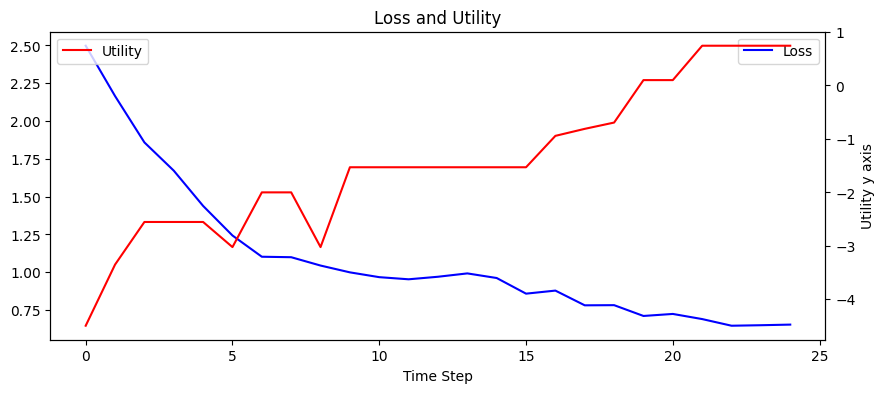

In [22]:
from backend.baseline_functions import train as train_, demo as demo_
# Get Iterators
train_iter, val_iter, test_iter = DataIterGen_V2(0, stockList1, demo=False, window=WINDOW)
# Training for COO 
os.makedirs('./model_weights', exist_ok=True)
TFJDRLconf_COO = full_monty(device=DEVICE, window=WINDOW, env_size=ENV_SIZE)
MAX_EPOCH = 25
optim1 = optim.Adam(TFJDRLconf_COO.parameters(),            lr=0.0001, weight_decay=0.01)
optim2 = optim.Adam(TFJDRLconf_COO.conf_net.parameters(),   lr=0.0025, weight_decay=0.01)

loss, conf_lst=train(train_iter, val_iter, net=TFJDRLconf_COO,
                optimizer1=optim1, optimizer2=optim2, device=DEVICE, num_epoch=MAX_EPOCH,
                name=NAME+'COO')

On average, every 28 days the algorithm yields: -4.69
The average confusion level is: 0.493
Using periods
Train: ('2013-01-01', '2017-10-01')
Test: ('2018-01-01', '2019-01-01')
Validation: ('2017-10-08', '2018-04-01')
Initializing Training Dataset...[DONE]
Demo Stock ticker: COO, change in closing price during testing period: $6.03


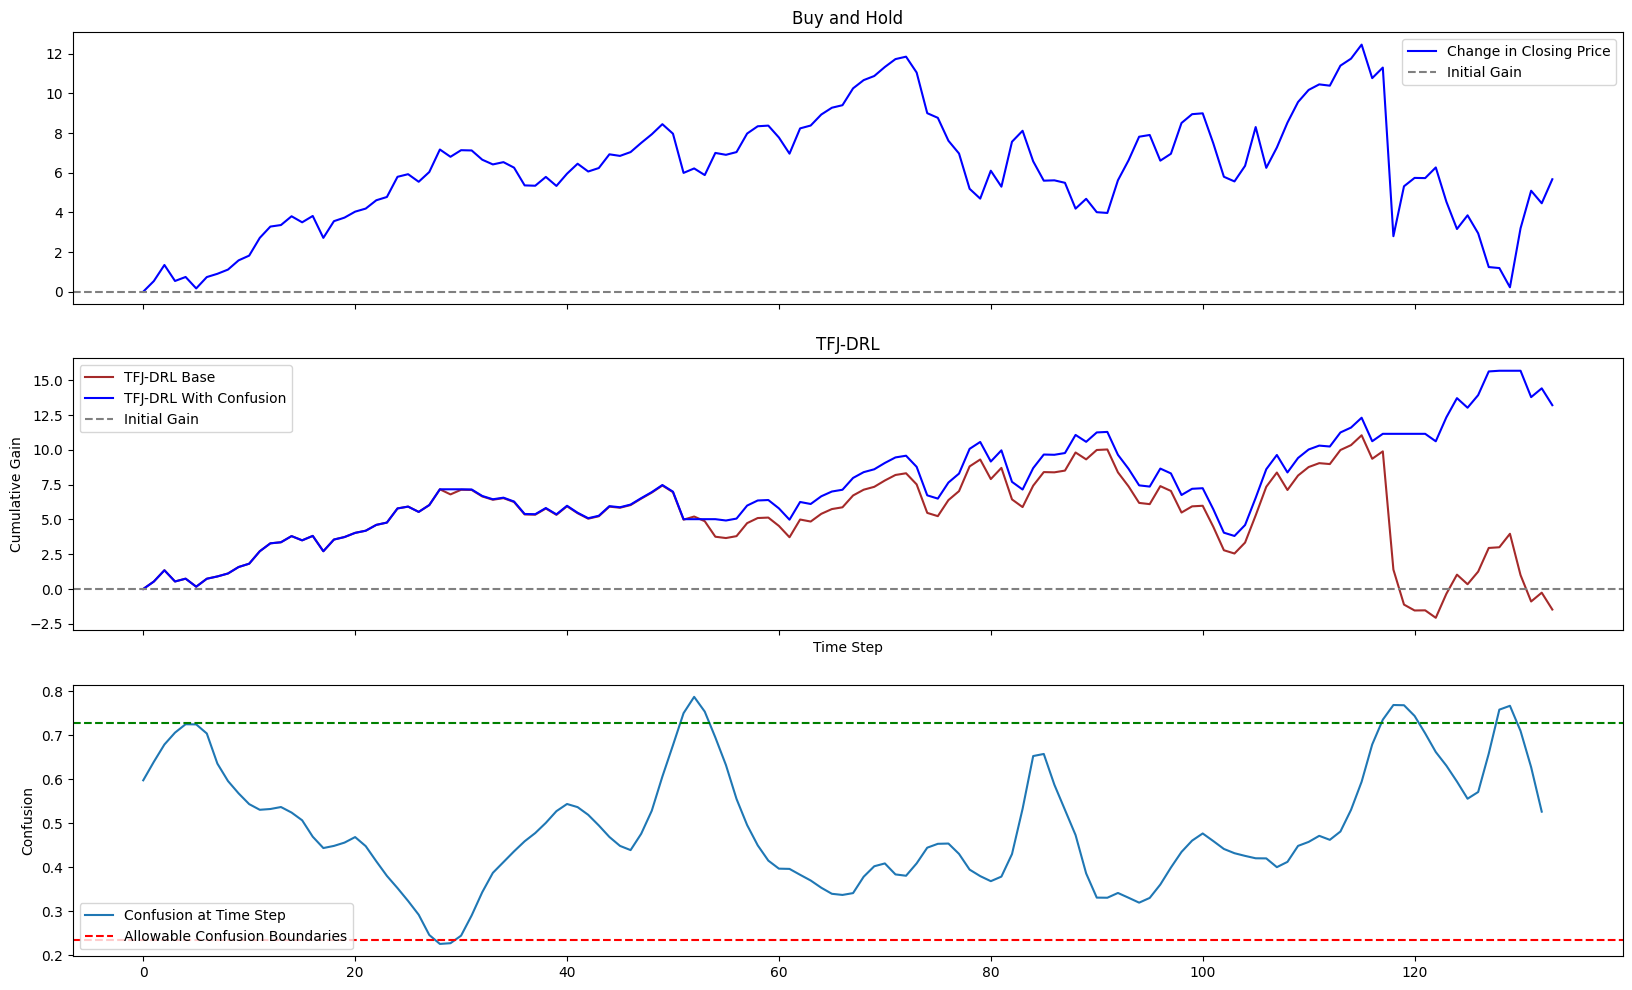

In [26]:
avgReturn, avgConf=test(net=TFJDRLconf_COO, test_iter=test_iter, device=DEVICE, epoch=MAX_EPOCH, name=NAME+'COO')
print(f'On average, every {WINDOW} days the algorithm yields: {avgReturn:.2f}' )
print(f'The average confusion level is: {avgConf:.3f}')
demo_iter = DataIterGen_V2(0, stockList1, demo=True, window=WINDOW)
# compute bounds for confusion heuristic
conf_bounds_COO=np.quantile(conf_lst, (.075, .75))
test_result, conf, stock_change, baseReturn = demo(net=TFJDRLconf_COO, demo_iter=demo_iter, device=DEVICE, epoch=MAX_EPOCH , name=NAME+'COO', conf_bounds=conf_bounds_COO)
#baseReturn, _, _ = demo_conf_noheur(net=TFJDRLconf_COO, demo_iter=demo_iter, device=DEVICE, epoch=MAX_EPOCH, name=NAME+'COO')
show_demo(result=test_result, stock_change=stock_change, baseline=baseReturn, conf_list=conf, conf_bounds=conf_bounds_COO)

# Train, Test and Demo with Capital One Financial Corp.

Using periods
Train: ('2013-01-01', '2017-10-01')
Test: ('2018-01-01', '2019-01-01')
Validation: ('2017-10-08', '2018-04-01')
Initializing Training Dataset...[DONE]
Initializing Iterators(dataloaders) From Dataset...[DONE]
Stock ticker: COF
Epoch 0, training loss: 2.24, val utility: 3.85, confusion: 0.832
Epoch 1, training loss: 2.03, val utility: 3.85, confusion: 0.790
Epoch 2, training loss: 1.89, val utility: 3.85, confusion: 0.840
Epoch 3, training loss: 1.73, val utility: 3.85, confusion: 0.724
Epoch 4, training loss: 1.55, val utility: 6.17, confusion: 0.739
Epoch 5, training loss: 1.41, val utility: 6.17, confusion: 0.746
Epoch 6, training loss: 1.30, val utility: 6.17, confusion: 0.707
Epoch 7, training loss: 1.22, val utility: 7.14, confusion: 0.747
Epoch 8, training loss: 1.12, val utility: 5.83, confusion: 0.965
Epoch 9, training loss: 1.04, val utility: 5.29, confusion: 0.960
Epoch 10, training loss: 1.02, val utility: 5.29, confusion: 0.865
Epoch 11, training loss: 0.98, v

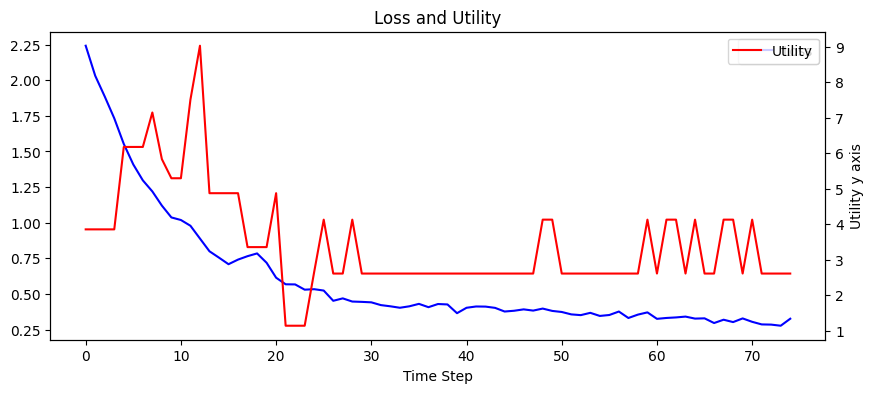

In [ ]:
from backend.baseline_functions import train as train_, demo as demo_
# Get Iterators
train_iter, val_iter, test_iter = DataIterGen_V2(1, stockList1, demo=False, window=WINDOW)
# Training for COF 
os.makedirs('./model_weights', exist_ok=True)
TFJDRLconf_COF = full_monty(device=DEVICE, window=WINDOW, env_size=ENV_SIZE)
optim1 = optim.Adam(TFJDRLconf_COF.parameters(),            lr=0.0001, weight_decay=0.01)
optim2 = optim.Adam(TFJDRLconf_COF.conf_net.parameters(),   lr=0.025, weight_decay=0.01)
loss, conf_data_COF=train(train_iter, val_iter, net=TFJDRLconf_COF,
                optimizer1=optim1, optimizer2=optim2, device=DEVICE, num_epoch=MAX_EPOCH,
                name=NAME+'COF')

On average, every 28 days the algorithm yields: -4.90
The average confusion level is: 0.524
Using periods
Train: ('2013-01-01', '2017-10-01')
Test: ('2018-01-01', '2019-01-01')
Validation: ('2017-10-08', '2018-04-01')
Initializing Training Dataset...[DONE]
Demo Stock ticker: COF, change in closing price during testing period: $-19.38


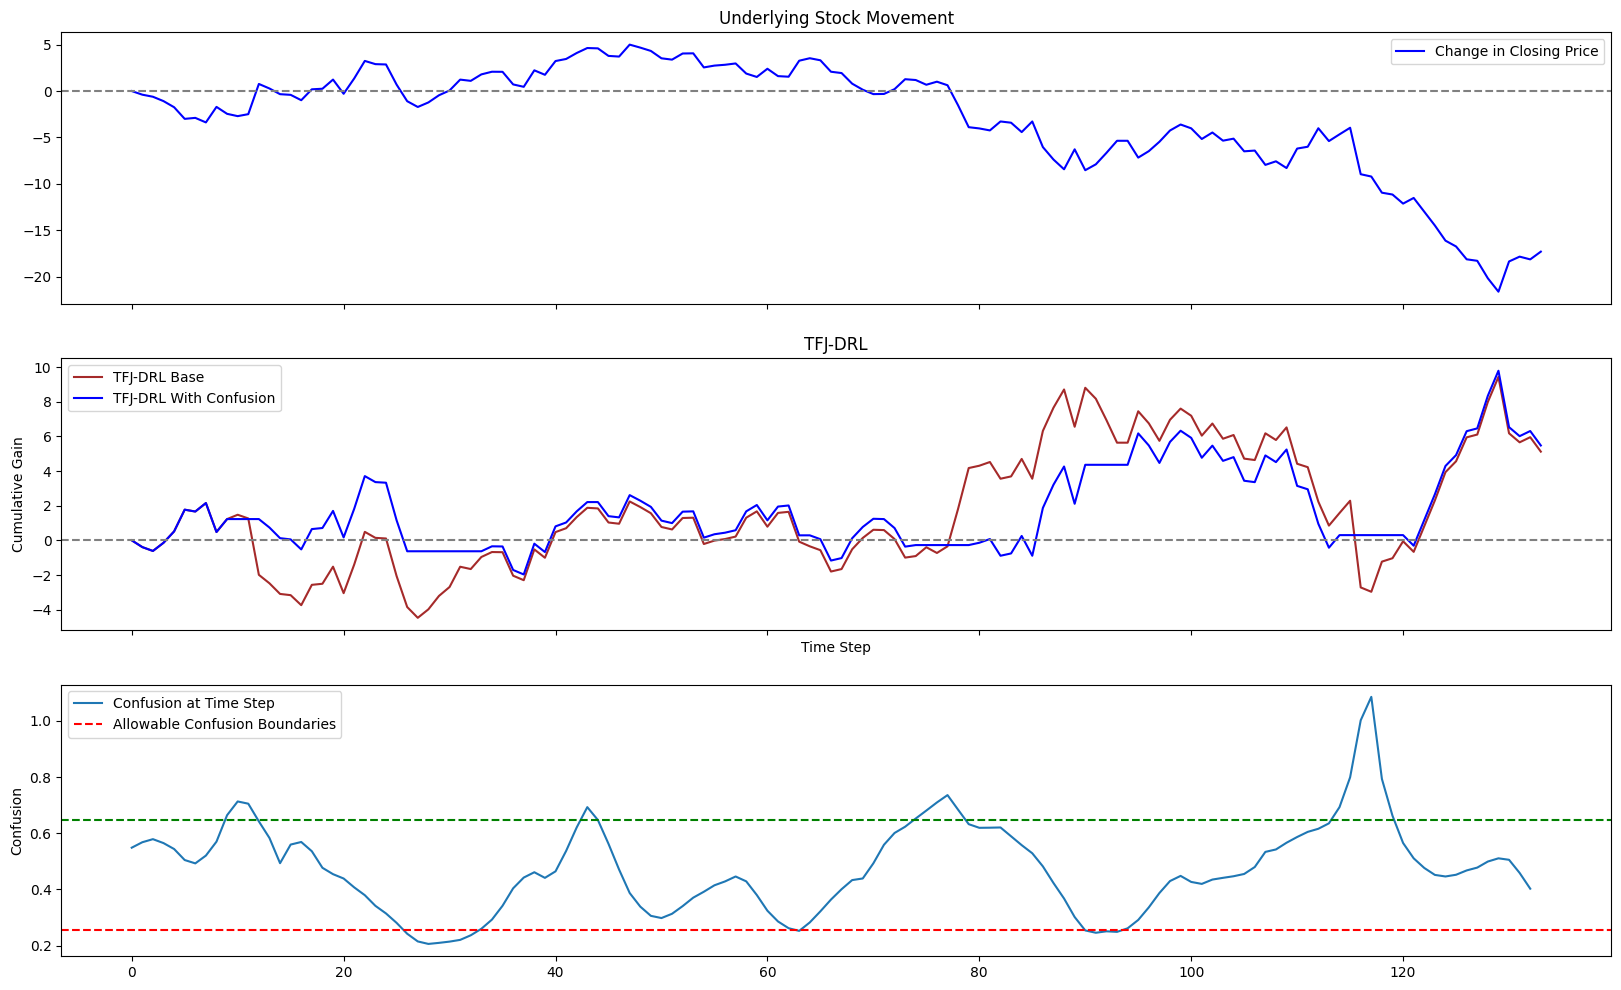

In [ ]:
TFJDRLconf_COF.eval()
avgReturn, avgConf=test(net=TFJDRLconf_COF, test_iter=test_iter, device=DEVICE, epoch=MAX_EPOCH, name=NAME+'COF')
print(f'The average confusion level is: {avgConf:.3f}')
# compute conf thresholds
conf_bounds_COF = np.quantile(conf_data_COF, (.15, .75))
demo_iter = DataIterGen_V2(1, stockList1, demo=True, window=WINDOW)
test_result, conf, stock_change, baseReturn = demo(net=TFJDRLconf_COF, demo_iter=demo_iter, device=DEVICE, epoch=MAX_EPOCH , name=NAME+'COO', conf_bounds=conf_bounds_COF)
show_demo(result=test_result, stock_change=stock_change, baseline=baseReturn, conf_list=conf, conf_bounds=conf_bounds_COF)